In [1]:
import meshio as mio
from npyfem.integrator import Integrator
import numpy as np
from npyfem.npmesh import NPMesh
from npyfem.solver import assemble_global_system, set_dirichlet_boundary_conditions

import scipy.sparse as sps
import scipy.sparse.linalg as splinalg
import scipy.optimize as opt

import matplotlib.pyplot as plt 
from timeit import default_timer as timer

# uncomment for fancy zoomable plots
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D


In [2]:
start = timer()
starttotal = timer()
outp = mio.read('../resources/beast_2d.msh')
end = timer()
print(end - start)    

0.005389540998294251


In [3]:
start = timer()
msh = NPMesh(*outp)
end = timer()
print(end - start)    

0.0045056379967718385


In [4]:
MEDIUM = 1
SOUTH_BOUND = 3
NORTH_BOUND = 2
WEST_BOUND = 4
EAST_BOUND = 5

temps = {
    SOUTH_BOUND: 60,
    NORTH_BOUND: 40,
    #WEST_BOUND: 20,
    #EAST_BOUND: 10
}

Stiffness matrix is
$$ K=\int_\Omega k<\nabla Ni,\nabla N_j> $$
where $k$ is the thermal conductivity, thought to be linear in this case. Boundary conditions are $T = T_1$ in north and $T = T_2$ in south.

In [5]:
k = 0.01
msh.ndofs

642

In [6]:
stiffmintegrator = Integrator(msh, 1)
sourceintegrator = Integrator(msh, 2)

The shapes are as follows 
$$ \mbox{integration points} \times \mbox{elements} \times \mbox{dof} \times \mbox{dof} \; . $$
This shape is efficient since the integration in the reference element can be done using np.tensorprod which uses efficient linear algebra libraries.

Now we can make the integration. This function integrates the given linear form in reference element over the whole domain. The return value is numpy array of $\mbox{elements} \times \mbox{dof} \times \mbox{dof}$ where $\mbox{dof}$ is the number of degrees of freedom in one element.

Notice how the numpy product $*$ which is elementwise multiplication works naturally here.

In [7]:
# helper function 
def innprod(a,b):
    return np.matmul(a.transpose((0,1,3,2)), b)

def linform_stiffmat(obj):
    return k*innprod(obj.dNxyz,obj.dNxyz)
    
def linform_source(obj):
    return 1*obj.N.transpose(0,1,3,2)

# make the integration 
start = timer()
intstiff = stiffmintegrator.integrate([MEDIUM], linform_stiffmat)
end = timer()
print(end - start)   
start = timer()
intsource = sourceintegrator.integrate([MEDIUM], linform_source)
end = timer()
print(end - start)    

0.0038949559966567904
0.0003867550003633369


The rest of the code assembles the global system imposes boundary conditions and solves it. These will be improved in the future.

In [8]:
start = timer()
#stiffmat assembly
K = assemble_global_system(msh, intstiff).tolil()
end = timer()
print(end - start)   

start = timer()
# sourcevec assembly
F = assemble_global_system(msh, intsource).tolil()
end = timer()
print(end - start)    

endtotal = timer()
print(endtotal - starttotal)   

0.0051262699998915195
0.0030505100003210828
0.0756688520013995


In [9]:
start = timer()
K,F = set_dirichlet_boundary_conditions(msh, K, F, temps)
end = timer()
print(end - start)    


start = timer()
# solve
T = sps.linalg.spsolve(K.tocsr(),F.tocsr())
end = timer()
print(end - start)    

0.0147817879987997
0.004861250999965705


<IPython.core.display.Javascript object>


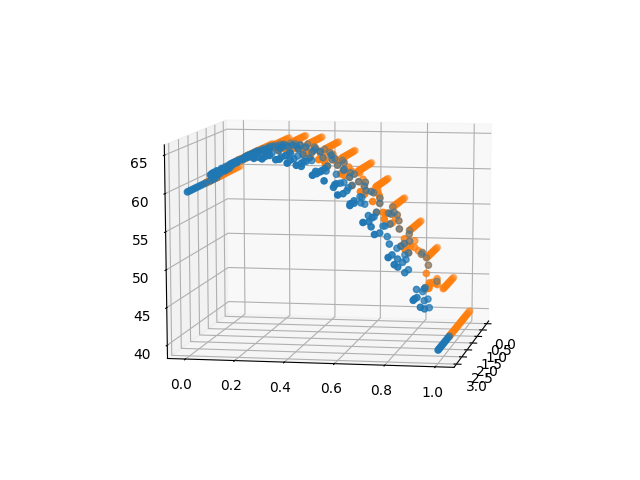

In [10]:
# just a testplot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

tri = msh.physicals[MEDIUM]['triangle']
qu = msh.physicals[MEDIUM]['quad']

xst = tri.lnode_coords[:,0]
yst = tri.lnode_coords[:,1]
Tt = T[tri.global_nodeids]

xsq = qu.lnode_coords[:,0]
ysq = qu.lnode_coords[:,1]
Tq = T[qu.global_nodeids]

ax.view_init(elev=10., azim=10)
ax.scatter(xst,yst,Tt)
ax.scatter(xsq, ysq,Tq)
plt.show()
